# Analisando as despesas por fornecedor do mes de Fevereiro de 2024

Fonte: https://sistemas.serafinacorrea.rs.gov.br/transparencia/?AcessoIndividual=lnkDespesasPor_Fornecedor


In [96]:
import pandas as pd
import time
import requests
import re
import json

In [97]:
df_jan = pd.read_excel('data/despesas_por_fornecedor_jan_2024.xlsx')
df_fev = pd.read_excel('data/despesas_por_fornecedor_fev_2024.xlsx')
df_mar = pd.read_excel('data/despesas_por_fornecedor_mar_2024.xlsx')


In [100]:
df_jan.head(1)


,Código,CNPJ/CPF,Descrição,Município,Valor Empenhado,Valor Liquidado,Valor Pago
0,359277.0,29.043.834/0001-66,3MED DISTRIBUIDORA DE MEDICAMENTOS LTDA.,Erechim,5507.88,0,0


In [101]:
df_fev.head(1)

,Código,CNPJ/CPF,Descrição,Município,Valor Empenhado,Valor Liquidado,Valor Pago
0,359277.0,29.043.834/0001-66,3MED DISTRIBUIDORA DE MEDICAMENTOS LTDA.,Erechim,-67,5440.88,5440.88


In [102]:
df_mar.head(1)

,Código,CNPJ/CPF,Descrição,Município,Valor Empenhado,Valor Liquidado,Valor Pago
0,359277.0,29.043.834/0001-66,3MED DISTRIBUIDORA DE MEDICAMENTOS LTDA.,Erechim,7250.76,0,0


In [25]:
df_jan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359 entries, 0 to 358
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Código           358 non-null    float64
 1   CNPJ/CPF         355 non-null    object 
 2   Descrição        358 non-null    object 
 3   Município        358 non-null    object 
 4   Valor Empenhado  359 non-null    object 
 5   Valor Liquidado  359 non-null    object 
 6   Valor Pago       359 non-null    object 
dtypes: float64(1), object(6)
memory usage: 19.8+ KB


In [103]:
# remove despesas sem código
df_jan = df_jan[~df_jan['Código'].isna()]
df_fev = df_fev[~df_fev['Código'].isna()]
df_mar = df_mar[~df_mar['Código'].isna()]

In [104]:
# remover as despesas sem CNPJ/CPF
df_jan = df_jan[~df_jan['CNPJ/CPF'].isna()]
df_fev = df_fev[~df_fev['CNPJ/CPF'].isna()]
df_mar = df_mar[~df_mar['CNPJ/CPF'].isna()]

In [105]:
#cria novas colunas de valores no formato numérico
df_jan['valor_empenhado'] = pd.to_numeric(df_jan['Valor Empenhado'])
df_fev['valor_empenhado'] = pd.to_numeric(df_fev['Valor Empenhado'])
df_mar['valor_empenhado'] = pd.to_numeric(df_mar['Valor Empenhado'])

df_jan['valor_liquidado'] = pd.to_numeric(df_jan['Valor Liquidado'])
df_fev['valor_liquidado'] = pd.to_numeric(df_fev['Valor Liquidado'])
df_mar['valor_liquidado'] = pd.to_numeric(df_mar['Valor Liquidado'])

df_jan['valor_pago'] = pd.to_numeric(df_jan['Valor Pago'])
df_fev['valor_pago'] = pd.to_numeric(df_fev['Valor Pago'])
df_mar['valor_pago'] = pd.to_numeric(df_mar['Valor Pago'])

In [106]:
df_jan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 355 entries, 0 to 357
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Código           355 non-null    float64
 1   CNPJ/CPF         355 non-null    object 
 2   Descrição        355 non-null    object 
 3   Município        355 non-null    object 
 4   Valor Empenhado  355 non-null    object 
 5   Valor Liquidado  355 non-null    object 
 6   Valor Pago       355 non-null    object 
 7   valor_empenhado  355 non-null    float64
 8   valor_liquidado  355 non-null    float64
 9   valor_pago       355 non-null    float64
dtypes: float64(4), object(6)
memory usage: 30.5+ KB


In [107]:
df_jan['cnpj'] = df_jan['CNPJ/CPF'].apply(lambda x: re.sub('[^0-9]', '', x))
df_fev['cnpj'] = df_fev['CNPJ/CPF'].apply(lambda x: re.sub('[^0-9]', '', x))
df_mar['cnpj'] = df_mar['CNPJ/CPF'].apply(lambda x: re.sub('[^0-9]', '', x))

In [108]:
df_jan = df_jan[['Código', 'Descrição', 'CNPJ/CPF', 'valor_empenhado', 'valor_liquidado', 'valor_pago', 'cnpj']]
df_fev = df_fev[['Código', 'Descrição', 'CNPJ/CPF', 'valor_empenhado', 'valor_liquidado', 'valor_pago', 'cnpj']]
df_mar = df_mar[['Código', 'Descrição', 'CNPJ/CPF', 'valor_empenhado', 'valor_liquidado', 'valor_pago', 'cnpj']]

In [109]:
#cria uma coluna com o mes informado de cada dataframe

df_jan = df_jan.assign(mes = 'janeiro')
df_fev = df_fev.assign(mes = 'fevereiro')
df_mar = df_mar.assign(mes = 'março')

df_jan = df_jan.assign(mes_int = 1)
df_fev = df_fev.assign(mes_int = 2)
df_mar = df_mar.assign(mes_int = 3)

In [111]:
df_trimestre = pd.concat([df_jan, df_fev, df_mar], ignore_index=True)

In [113]:
df_trimestre.mes.unique()

array(['janeiro', 'fevereiro', 'março'], dtype=object)

Para plotar o mapa, preciso do municipio e uf, porém, existem municípios com o mesmo nome quando se tira o acento, exemplo:

Marau/RS
Maraú/BA

Para garantir que a marcação seja feita nas coordenadas corretas, preciso buscar a UF em algum lugar. 

Encontrei a api https://publica.cnpj.ws/cnpj/{cnpj-sem-mascara} que retorna diversos dados, inclusive o endereço que eu preciso.

Solução: criar a coluna uf no df e popular com os dados encontrados na api

a api bem legal não deixa eu fazer mais que três requisições por minuto =/

In [114]:
#para cada linha do dataframe eu quero fazer uma requisição à uma api para buscar a uf passando a coluna cnpj como parametro na requisicao

def get_uf_from_cnpj(cnpj):    
    cnpj= re.sub('[^0-9]', '', cnpj) # 123
    url = f"https://publica.cnpj.ws/cnpj/{cnpj}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        empresa =  {
                        'cnpj': data['estabelecimento']['cnpj'],
                        'razao_social': data['razao_social'],
                        'uf': data['estabelecimento']['estado']['sigla'],
                        'cidade': data['estabelecimento']['cidade']['nome'],
                        'cidade_ibge_id': data['estabelecimento']['cidade']['ibge_id']
                }
        print(empresa['cnpj'], empresa['razao_social'], empresa['cidade'])
        return empresa
    else:
        return None

In [115]:
#carregando os cnpjs que eu teinho na manga
cnpjs_df = pd.read_csv('empresas.csv', dtype={'cnpj': str})

print(f"Total de linhas antigas: {cnpjs_df.shape[0]}")

Total de linhas antigas: 450


In [116]:
# aqui, busco só os novos na api
cnpj_novos = df_trimestre[~df_trimestre['cnpj'].isin(cnpjs_df['cnpj'])]['cnpj'].unique() 
print(f"Total de linhas a buscar: {cnpj_novos.shape[0]}")        

Total de linhas a buscar: 81


In [117]:
cnpjs = []
for i in cnpj_novos:
    if len(i) == 14:
         cnpjs.append(get_uf_from_cnpj(i))
         time.sleep(21)
    #else:
        #print(i)

In [118]:
# criar um dataframe 
cnpjs_novos_df = pd.DataFrame(cnpjs)
print(f"Total de linhas novas: {cnpjs_novos_df.shape[0]}")

Total de linhas novas: 0


In [119]:
# unindo os dataframes de cnpjs que eu já tinha com os novos
cnpjs_df_atualizado = cnpjs_df
if cnpjs_novos_df.shape[0] > 0:
    cnpjs_df_atualizado = pd.concat([cnpjs_df, cnpjs_novos_df], ignore_index=True)

In [120]:
print(f"Total de linhas atualizado: {cnpjs_df_atualizado.shape[0]}")

Total de linhas atualizado: 450


In [121]:
cnpjs_df_atualizado.to_csv('empresas.csv')

In [124]:
df_trimestre.head()

,Código,Descrição,CNPJ/CPF,valor_empenhado,valor_liquidado,valor_pago,cnpj,mes,mes_int
0,359277.0,3MED DISTRIBUIDORA DE MEDICAMENTOS LTDA.,29.043.834/0001-66,5507.88,0.0,0.0,29043834000166,janeiro,1
1,359612.0,51.140.560 IVANETE TERESINHA LUFT BALDISSERA,51.140.560/0001-82,5980.00,0.0,0.0,51140560000182,janeiro,1
2,359175.0,A M COMERCIO DE PRODUTOS DE LIMPEZA LTDA,45.212.009/0001-02,2352.64,0.0,0.0,45212009000102,janeiro,1
3,326093.0,A. ROSSATTO FONOAUDIOLOGIA,33.811.873/0001-33,4944.60,0.0,0.0,33811873000133,janeiro,1
4,4204.0,A.A.F. LABORATÓRIO DE ANÁLISES CLÍNICAS LTDA,04.567.872/0001-97,80000.00,0.0,0.0,04567872000197,janeiro,1


In [125]:
df_trimestre.tail()

,Código,Descrição,CNPJ/CPF,valor_empenhado,valor_liquidado,valor_pago,cnpj,mes,mes_int
1200,311738.0,WEL DISTRIBUIDORA DE MEDICAMENTOS E PRODUTOS P...,11.318.264/0001-04,1693.32,0.00,0.00,11318264000104,março,3
1201,326130.0,WILLIAN JURANDIR DA SILVA,05.769.326/0001-00,0.00,6551.28,6551.28,05769326000100,março,3
1202,323725.0,ZAFRA SUL INDUSTRIA DE UNIFIRMES PROFISSIONAIS...,15.450.716/0001-68,0.00,960.00,960.00,15450716000168,março,3
1203,357679.0,"ZILLI, MARTINS E TREMARIN SOCIEDADE DE ADVOGADOS",28.750.316/0001-10,78736.98,8133.51,8133.51,28750316000110,março,3
1204,43083.0,ZILOVANO MAIQUEL ENDERLE,08.040.226/0001-28,250.00,250.00,250.00,08040226000128,março,3


In [126]:
cnpjs_nao_encontrados = df_trimestre[~df_trimestre['cnpj'].isin(cnpjs_df['cnpj'])]

In [127]:
cnpjs_nao_encontrados[['CNPJ/CPF']]

,CNPJ/CPF
13,008.XXX.130-03
15,753.XXX.730-04
18,577.XXX.620-72
27,438.XXX.470-53
28,905.XXX.090-72
...,...
1145,034.XXX.160-08
1147,687.XXX.400-53
1151,412.XXX.970-20
1188,412.XXX.340-20


In [128]:
df_trimestre[df_trimestre['cnpj'].str.len() == 14]['cnpj'].unique().size

450

Agora, vou fazer o merge com o dataframe de empresas para pegar o endereço correto

In [129]:
despesas_fornecedor = pd.merge(df_trimestre, cnpjs_df, on='cnpj', how='left')

In [131]:
despesas_fornecedor.mes.unique()

array(['janeiro', 'fevereiro', 'março'], dtype=object)

que coisa linda!!! S2
Agora vou criar um novo df com as coordenadas de municipios

In [132]:
df_municipios = pd.read_csv('https://raw.githubusercontent.com/kelvins/municipios-brasileiros/194cfcc3062dfc8a8f55bfdc9a630b3aee1f59f4/csv/municipios.csv')

dá pra usar o codigo ibge para o merge. maravilha! 
só tem que tratar o codigo pq estão com tipos diferentes em cada dataframe

In [133]:
print(despesas_fornecedor['cidade_ibge_id'].describe())
print(df_municipios['codigo_ibge'].describe())

count    1.048000e+03
mean     4.304662e+06
std      2.237226e+05
min      3.106200e+06
25%      4.309407e+06
50%      4.314902e+06
75%      4.320404e+06
max      5.300108e+06
Name: cidade_ibge_id, dtype: float64
count    5.570000e+03
mean     3.253591e+06
std      9.849103e+05
min      1.100015e+06
25%      2.512126e+06
50%      3.146280e+06
75%      4.119190e+06
max      5.300108e+06
Name: codigo_ibge, dtype: float64


hmm, era tudo float... to doidão. bora merja sabagaça

In [134]:
despesas_fornecedor_com_municipios = pd.merge(
    despesas_fornecedor, 
    df_municipios, 
    left_on='cidade_ibge_id', 
    right_on='codigo_ibge', 
    suffixes=('_despesas_fornecedor', '__municipios'), how='left'
)

In [73]:
# despesas_fornecedor_com_municipios.columns.to_list()

In [135]:
despesas_fornecedor_com_municipios.rename(columns={'nome': 'municipio'}, inplace=True)

In [136]:
cnpjs_df[cnpjs_df['cnpj'] == '14373681000148']['razao_social']

285    FUNDO DE PREVIDENCIA SOCIAL DO MUNICIPIO DE SE...
Name: razao_social, dtype: object

In [139]:
despesas_fornecedor_com_municipios.head()

,Código,Descrição,CNPJ/CPF,valor_empenhado,valor_liquidado,valor_pago,cnpj,mes,mes_int,Unnamed: 0.9,...,cidade_ibge_id,codigo_ibge,municipio,latitude,longitude,capital,codigo_uf,siafi_id,ddd,fuso_horario
0,359277.0,3MED DISTRIBUIDORA DE MEDICAMENTOS LTDA.,29.043.834/0001-66,5507.88,0.0,0.0,29043834000166,janeiro,1,0.0,...,4307005.0,4307005.0,Erechim,-27.6364,-52.2697,0.0,43.0,8637.0,54.0,America/Sao_Paulo
1,359612.0,51.140.560 IVANETE TERESINHA LUFT BALDISSERA,51.140.560/0001-82,5980.00,0.0,0.0,51140560000182,janeiro,1,2.0,...,4309407.0,4309407.0,Guaporé,-28.8399,-51.8895,0.0,43.0,8687.0,54.0,America/Sao_Paulo
2,359175.0,A M COMERCIO DE PRODUTOS DE LIMPEZA LTDA,45.212.009/0001-02,2352.64,0.0,0.0,45212009000102,janeiro,1,3.0,...,4320503.0,4320503.0,Sertão,-27.9798,-52.2588,0.0,43.0,8911.0,54.0,America/Sao_Paulo
3,326093.0,A. ROSSATTO FONOAUDIOLOGIA,33.811.873/0001-33,4944.60,0.0,0.0,33811873000133,janeiro,1,4.0,...,4320404.0,4320404.0,Serafina Corrêa,-28.7126,-51.9352,0.0,43.0,8909.0,54.0,America/Sao_Paulo
4,4204.0,A.A.F. LABORATÓRIO DE ANÁLISES CLÍNICAS LTDA,04.567.872/0001-97,80000.00,0.0,0.0,04567872000197,janeiro,1,5.0,...,4320404.0,4320404.0,Serafina Corrêa,-28.7126,-51.9352,0.0,43.0,8909.0,54.0,America/Sao_Paulo


In [140]:
dados_agrupados = despesas_fornecedor_com_municipios.groupby(['municipio', 'uf', 'latitude', 'longitude']).agg(
    {'valor_empenhado': 'sum', 'valor_liquidado': 'sum', 'valor_pago': 'sum', 'cnpj':'count'}
    ).sort_values(by='valor_empenhado', ascending=False)

In [141]:
dados_agrupados.reset_index(inplace=True)

In [142]:
dados_agrupados.to_excel('dados_agrupados-q1.xlsx')

In [143]:
import folium
import math
mapa = folium.Map(location=(-28.710129, -51.932609), zoom_start=4,  tiles='cartodbdark_matter')

#mapa
valor_empenhado_min = dados_agrupados['valor_empenhado'].min()
valor_empenhado_max = dados_agrupados['valor_empenhado'].max()

print(valor_empenhado_max, valor_empenhado_min)

for index, a in dados_agrupados.iterrows():    
    municipio = a['municipio']
    latitude = a['latitude']
    longitude = a['longitude']
    valor_empenhado = a['valor_empenhado']
        
    
    radius = valor_empenhado / valor_empenhado_max 
    if not math.isnan(latitude) and not math.isnan(longitude) and valor_empenhado > 0:
        folium.CircleMarker(
          location=[latitude, longitude],
          radius=radius*10,
          color="red",
          weight=5,
          fill_opacity=0.6,
          opacity=1,
          fill_color="#E8710A",
          fill=False,  # gets overridden by fill_color
          popup="Valor Empenhado R${}".format(valor_empenhado),
          tooltip=municipio,
          zoom_control=False,
          scrollWheelZoom=False,
        ).add_to(mapa)


mapa.save('index.html')

mapa


15110359.94 75.65


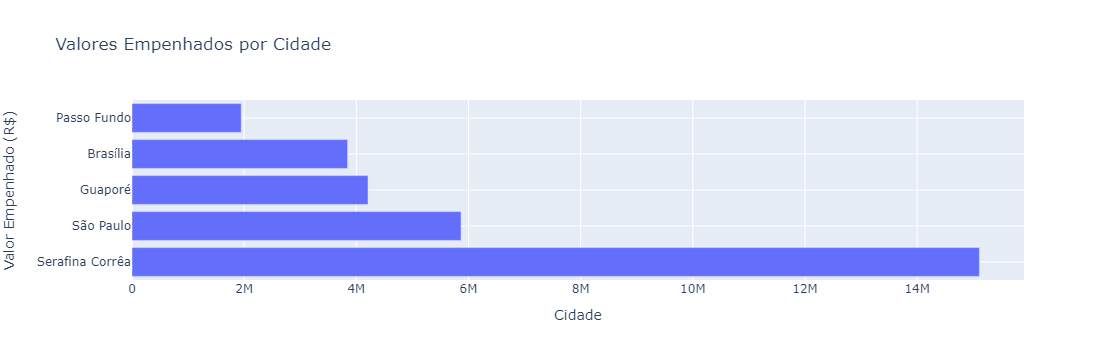

,municipio,uf,latitude,longitude,valor_empenhado,valor_liquidado,valor_pago,cnpj
0,Serafina Corrêa,RS,-28.7126,-51.9352,15110359.94,5727055.23,5700582.94,391
1,São Paulo,SP,-23.5329,-46.6395,5867466.07,2126801.54,2126801.54,12
2,Guaporé,RS,-28.8399,-51.8895,4208558.38,975744.38,897088.38,57
3,Brasília,DF,-15.7795,-47.9297,3844454.69,1016795.93,949211.30,22
4,Passo Fundo,RS,-28.2576,-52.4091,1947719.23,597011.47,451679.69,62


In [144]:
import plotly.graph_objects as go
import pandas as pd

df = dados_agrupados[0:5]

fig = go.Figure(data=[go.Bar(x=df["valor_empenhado"], y=df["municipio"], orientation='h')])

fig.update_layout(title="Valores Empenhados por Cidade",
                  xaxis_title="Cidade",
                  yaxis_title="Valor Empenhado (R$)",
                  bargap=0.2,
                  barmode='group',
                  xaxis_showgrid=True,
                  yaxis_showgrid=True)

fig.show()


dados_agrupados[0:5]

In [145]:
# quantos estados?
dados_agrupados.uf.unique().size

9

In [146]:
# quantos municipios?
dados_agrupados.municipio.unique().size

95

In [147]:
# quantas empresas?
dados_agrupados.cnpj.sum()

1048

In [148]:
despesas_fornecedor_com_municipios.to_csv('despesas_fornecedor_com_municipios_Q1.csv')

In [149]:
despesas_fornecedor_com_municipios.mes.unique()

array(['janeiro', 'fevereiro', 'março'], dtype=object)

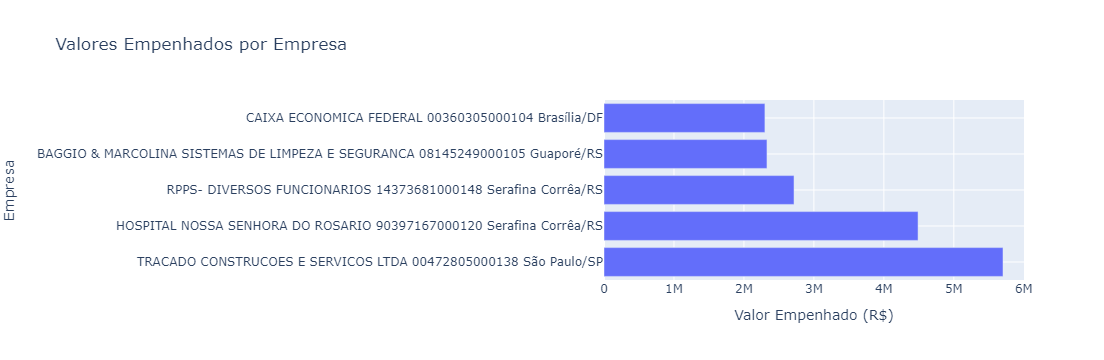

In [150]:
df = despesas_fornecedor_com_municipios.sort_values(by= 'valor_empenhado', ascending=False)[0:5]

df = df[~df['Código'].isna()]
df = df[~df['CNPJ/CPF'].isna()]


fig = go.Figure(data=[go.Bar(x=df["valor_empenhado"], y=df["Descrição"] + ' ' + df["cnpj"] + ' ' + df["municipio"] + '/' + df["uf"], orientation='h')])

fig.update_layout(title="Valores Empenhados por Empresa",
                  xaxis_title="Valor Empenhado (R$)",
                  yaxis_title="Empresa",
                  bargap=0.2,
                  barmode='group',
                  xaxis_showgrid=True,
                  yaxis_showgrid=True)

fig.show()




In [ ]:
#top 5
df[['Descrição', 'cnpj', 'municipio', 'uf', 'valor_empenhado']]

In [170]:
dados_agrupados_meses = despesas_fornecedor_com_municipios.groupby(['mes', 'mes_int']).agg(
    {'valor_empenhado': 'sum', 'valor_liquidado': 'sum', 'valor_pago': 'sum', 'cnpj':'count'}
    ).sort_values(by='valor_empenhado', ascending=False)

dados_agrupados_meses.reset_index(inplace=True)


In [204]:
dados_agrupados_meses.to_csv('data/dados_agrupados_meses')

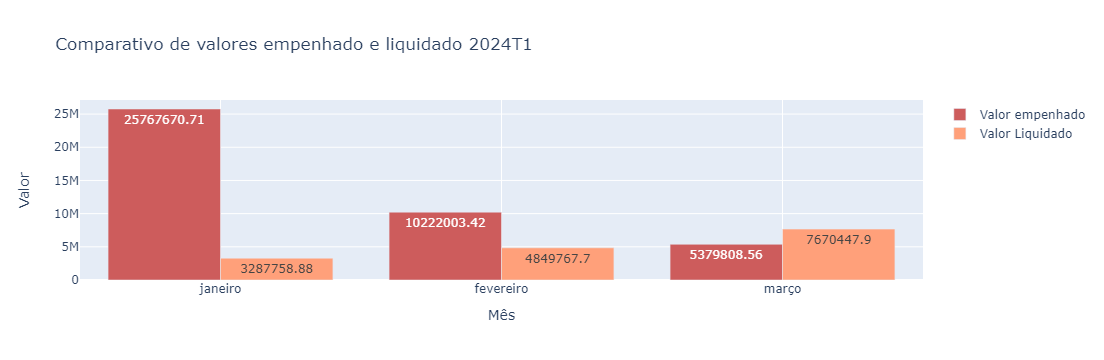

In [201]:


fig = go.Figure()
fig.add_trace(go.Bar(
    x=dados_agrupados_meses['mes'],
    y=dados_agrupados_meses['valor_empenhado'],
    name='Valor empenhado',
    marker_color='indianred',   
    text=dados_agrupados_meses['valor_empenhado']
))
fig.add_trace(go.Bar(
    x=dados_agrupados_meses['mes'],
    y=dados_agrupados_meses['valor_liquidado'],
    name='Valor Liquidado',
    marker_color='lightsalmon',
    text=dados_agrupados_meses['valor_liquidado']
))

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
#fig.update_layout(barmode='group', xaxis_tickangle=0)

fig.update_layout(title="Comparativo de valores empenhado e liquidado 2024T1",
                  xaxis_title="Mês",
                  yaxis_title="Valor",
                  bargap=0.2,
                  barmode='group',
                  xaxis_showgrid=True,
                  yaxis_showgrid=True
                  )

fig.show()